[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/Chapter-11/Red_Teaming_an_XGBoost_model.ipynb) 

# Chapter 11: Red-Teaming an XGBoost Credit Model

## Attacks for Red-teaming 


## 1. Setting the environment

Download the [zipped **data_and_package** folder](https://github.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/data_and_package.zip) onto your local system and save it as `Data.zip`. 

In [ ]:
# Upload the downloaded zipped file from your system to the colab environment. 
from google.colab import files
uploaded = files.upload()

Saving Data.zip to Data.zip


In [ ]:
!unzip -q "/content/Data.zip" 
%cd /content/Data

/content/Data


In [ ]:
# Installing the libraries
%pip install h2o 
%pip install 'XGBoost==1.6'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177.4 MB 39 kB/s 
  Created wheel for h2o: filename=h2o-3.38.0.2-py2.py3-none-any.whl size=177521195 sha256=0375a3f2940cbab562e0db442e17c2ba5498a03021a79e7018df0794bf162b0a
  Stored in directory: /root/.cache/pip/wheels/e4/ef/ab/a9b2e452e18b3dfea0b6114bc57c3b9e8b0e464eb2d03230e1
Successfully built h2o
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 193.7 MB 29 kB/s 
  Attempting uninstall: XGBoost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


Global hyperpameters


In [ ]:
SEED = 3141 # global random seed for better reproducibility

Python imports and inits

In [ ]:
import h2o
from h2o.estimators import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz

h2o.init(max_mem_size='4G')
h2o.remove_all()
h2o.no_progress()

SEED = SEED

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.16" 2022-07-19; OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu118.04); OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu118.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpf58uumk0
  JVM stdout: /tmp/tmpf58uumk0/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpf58uumk0/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_unknownUser_8t7xrm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


### Importing dataset 

In [ ]:
data = pd.read_csv('../Data/credit_line_increase.csv')
data.head()

,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DELINQ_NEXT
0,1,20000,2,1.0,2,1,24,2,2,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2.0,2,2,26,-1,2,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,3.0,2,2,34,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,4.0,2,1,37,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,3.0,2,1,57,-1,0,-1,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Assign target and inputs for models
Note that Demographic features are not used as model inputs.

In [ ]:
id_col = 'ID'
groups = ['SEX', 'RACE', 'EDUCATION', 'MARRIAGE', 'AGE']
target = 'DELINQ_NEXT'
demographic_cols = ['SEX', 'RACE','EDUCATION', 'MARRIAGE', 'AGE']

### Splitting dataset into train, validation and test set

In [ ]:
np.random.seed(SEED)

split_train_test = 2/3

split = np.random.rand(len(data)) < split_train_test
train = data[split].copy()
test = data[~split].copy()

split_test_valid = 1/2

split = np.random.rand(len(test)) < split_test_valid
valid = test[split].copy()
test = test[~split].copy()

del data

print(f"Train/Validation/Test sizes: {len(train)}/{len(valid)}/{len(test)}")

Train/Validation/Test sizes: 19958/5036/5006


### Converting Pandas dataframe into H2O Frame

In [ ]:
features = [col for col in train.columns if col not in groups + ['ID', target]]

# Converting Pandas dataframe into H2O Frame
training_frame = h2o.H2OFrame(train)
validation_frame = h2o.H2OFrame(valid)
test_frame = h2o.H2OFrame(test)

# Setting target column to factor so we can build classification model
training_frame[target] = training_frame[target].asfactor()
validation_frame[target] = validation_frame[target].asfactor()
test_frame[target] = test_frame[target].asfactor()

## 2. Training an H2O XGBoost model



### Setting XGBooost Parameters

In [ ]:
param = {
      "ntrees" : 100
    , "max_depth" : 10
    , "learn_rate" : 0.1
    , "sample_rate" : 0.9
    , "col_sample_rate_per_tree" : 1
    , "min_rows" : 5
    , "seed": SEED
    , "score_tree_interval": 10
}

xgb_clf = H2OXGBoostEstimator(**param)
xgb_clf = xgb_clf.train(x=features, y=target, 
                        training_frame=training_frame, validation_frame=validation_frame)

### Investigating Pairwise Spearman Correlations with the Target Variable

In [ ]:
corr = pd.DataFrame(train[features + [target]].corr(method='spearman')[target]).iloc[:-1]
corr.columns = ['Spearman Correlation Coefficient']

values = [int(i) for i in np.sign(corr.values)]
mono_constraints = dict(zip(corr.index, values))

### Train XGBoost with  L2 Regularisation

Using grid Search to find the best hyperparameter values

In [ ]:
# params obtained out of grid Search
params_best = {'reg_lambda': 0.25,
               'min_child_weight': 1,
               'eta': 0.08,
               'sample_rate': 0.8,
               'col_sample_rate_per_tree': 0.8,
               'max_depth': 3}

xgb_best = H2OXGBoostEstimator(**params_best, 
                               monotone_constraints=mono_constraints)

xgb_best = xgb_best.train(x=features, y=target, 
                          training_frame=training_frame, 
                          validation_frame=validation_frame)

/usr/local/lib/python3.7/dist-packages/h2o/estimators/estimator_base.py:193: RuntimeWarning: Using user-provided parameter eta instead of learn_rate."
  warnings.warn(mesg["message"], RuntimeWarning)


## 3. Model Extraction Attacks

Model Extraction is a confidentiality attack, meaning it compromises the confi‐
dentiality of an ML model. To conduct a model extraction attack, a hacker sub‐
mits data to a prediction API, gets predictions back and builds a surrogate model
between the submitted data and the received predictions to reverse-engineer a
copy of the model. With this information, they may uncover proprietary business
processes and decision-making.

In [ ]:
# We'll suppose access to a model prediction API endpoint that we can query without restriction

def model_endpoint(observations: pd.DataFrame):
    pred_frame = h2o.H2OFrame(observations)
    prediction = xgb_clf.predict(pred_frame)['p1'].as_data_frame().values
    return prediction


In [ ]:
# best guess at feature distributions
schema_dict = {'PAY_0': {'values': np.arange(-1, 10), 'dist': 'uniform'},
               'PAY_2': {'values': np.arange(-1, 10), 'dist': 'uniform'},
               'PAY_3': {'values': np.arange(-1, 10), 'dist': 'uniform'},
               'PAY_4': {'values': np.arange(-1, 10), 'dist': 'uniform'},
               'PAY_5': {'values': np.arange(-1, 10), 'dist': 'uniform'},
               'PAY_6': {'values': np.arange(-1, 10), 'dist': 'uniform'},
               'LIMIT_BAL': {'min': 500, 'scale': 1000000, 'dist': 'exponential'},
               'BILL_AMT1': {'min': 0, 'scale': 600000, 'dist': 'exponential'},
               'BILL_AMT2': {'min': 0, 'scale': 600000, 'dist': 'exponential'},
               'BILL_AMT3': {'min': 0, 'scale': 600000, 'dist': 'exponential'},
               'BILL_AMT4': {'min': 0, 'scale': 600000, 'dist': 'exponential'},
               'BILL_AMT5': {'min': 0, 'scale': 600000, 'dist': 'exponential'},
               'BILL_AMT6': {'min': 0, 'scale': 600000, 'dist': 'exponential'},
               'PAY_AMT1': {'min': 0, 'scale': 300000, 'dist': 'exponential'},
               'PAY_AMT2': {'min': 0, 'scale': 300000, 'dist': 'exponential'},
               'PAY_AMT3': {'min': 0, 'scale': 300000, 'dist': 'exponential'},
               'PAY_AMT4': {'min': 0, 'scale': 300000, 'dist': 'exponential'},
               'PAY_AMT5': {'min': 0, 'scale': 300000, 'dist': 'exponential'},
               'PAY_AMT6': {'min': 0, 'scale': 300000, 'dist': 'exponential'}}

N = 50000 # rows of simulated data
np.random.seed(SEED) # same results each time cell is run    

def make_random_frame(schema, N):
    random_frame = pd.DataFrame(columns=list(schema_dict.keys())) # init empty frame


    for j in list(schema_dict.keys()): # loop through features

        # simulate PAY_* features
        if schema_dict[j]['dist'] == 'uniform':
            random_frame[j] = np.random.choice(schema_dict[j]['values'],
                                               size=N)

        # simulate LIMIT_BAL, BILL_AMT*, PAY_AMT* features
        if schema_dict[j]['dist'] == 'exponential':
            random_frame[j] = schema_dict[j]['min'] + np.random.exponential(scale=schema_dict[j]['scale'], 
                                                                            size=N)
            
    return random_frame

random_frame = make_random_frame(schema_dict, N)

In [ ]:
# We augmented the random data above with another data synthesis technique that leverages 
#  access to the model endpoint.

random_frame = pd.read_csv('../Data/synthetic_data.csv', index_col=0)

split = np.random.rand(len(random_frame)) < split_train_test
random_train = random_frame[split].copy()
random_test = random_frame[~split].copy()

split = np.random.rand(len(random_test)) < split_test_valid
random_valid = random_test[split].copy()
random_test = random_test[~split].copy()

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score

surrogate_model_params = {'max_depth': 3,
                         'random_state': SEED}
extracted_model_dt = DecisionTreeRegressor(**surrogate_model_params).fit(random_train[features], 
                                                                         model_endpoint(random_train[features]))

r2_train = r2_score(y_true=model_endpoint(random_train[features]), 
                     y_pred=extracted_model_dt.predict(random_train[features]))
r2_test = r2_score(y_true=model_endpoint(random_test[features]), 
                     y_pred=extracted_model_dt.predict(random_test[features]))
r2_holdout = r2_score(y_true=model_endpoint(test[features]), 
                     y_pred=extracted_model_dt.predict(test[features]))

print(f'R2 on training data (simulated): {np.round(r2_train, 3)}')
print(f'R2 on test data (simulated): {np.round(r2_test, 3)}')
print(f'R2 on real data: {np.round(r2_holdout, 3)}')

print(f'real/test: {r2_holdout/r2_test}')

R2 on training data (simulated): 0.605
R2 on test data (simulated): 0.601
R2 on real data: 0.608
real/test: 1.0120976812025775


In [ ]:
from sklearn.metrics import mean_absolute_error

mae_test = mean_absolute_error(y_true=model_endpoint(random_test[features]), 
                              y_pred=extracted_model_dt.predict(random_test[features]))

mae_holdout = mean_absolute_error(y_true=model_endpoint(test[features]), 
                                 y_pred=extracted_model_dt.predict(test[features]))

print(f'MAE on test data (simulated): {np.round(mae_test, 5)}')
print(f'MAE on real data: {np.round(mae_holdout, 5)}')

print(f'test/real: {mae_test/mae_holdout}')

MAE on test data (simulated): 0.0825
MAE on real data: 0.09586
test/real: 0.860618968222088


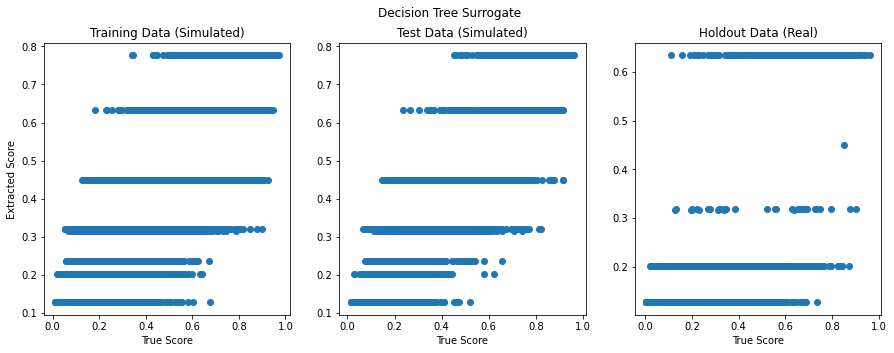

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(model_endpoint(random_train[features]), extracted_model_dt.predict(random_train[features]))
axs[0].set_title("Training Data (Simulated)")
axs[0].set_ylabel('Extracted Score')
axs[0].set_xlabel('True Score')

axs[1].scatter(model_endpoint(random_test[features]), extracted_model_dt.predict(random_test[features]))
axs[1].set_title("Test Data (Simulated)")
axs[1].set_xlabel('True Score')


axs[2].scatter(model_endpoint(test[features]), extracted_model_dt.predict(test[features]))
axs[2].set_title("Holdout Data (Real)")
axs[2].set_xlabel('True Score')

_ = fig.suptitle("Decision Tree Surrogate")
fig.savefig('Data/Data/Figures/overfit_DT_extraction')

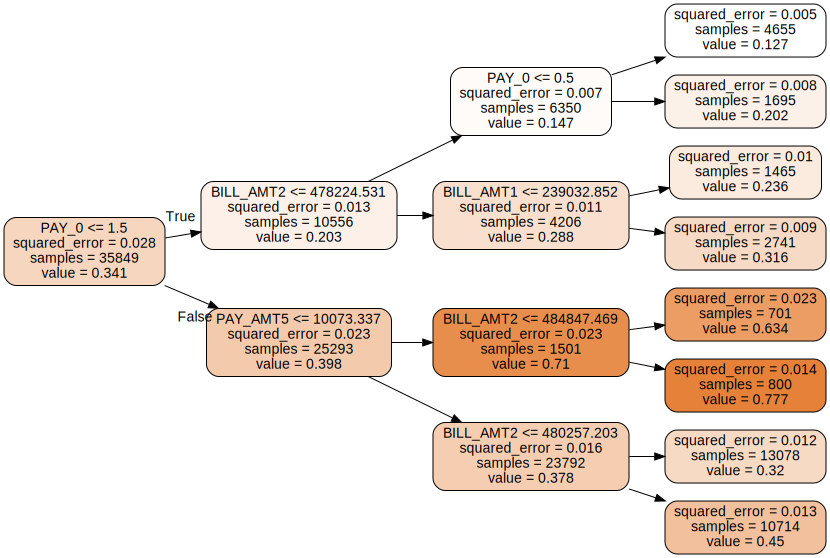

In [ ]:


dot_data = tree.export_graphviz(extracted_model_dt, 
                                max_depth=5,
                                rounded=True,
                                out_file=None, 
                                feature_names=features,  
                                filled=True,
                                rotate=True)

graph = graphviz.Source(dot_data, format="svg") 
graph


In [ ]:
drand_train = xgb.DMatrix(random_train[features], 
                          label=model_endpoint(random_train[features]))

drand_valid = xgb.DMatrix(random_valid[features], 
                          label=model_endpoint(random_valid[features]))

drand_test = xgb.DMatrix(random_test[features], 
                          label=model_endpoint(random_test[features]))

base_score = model_endpoint(random_train[features]).mean()

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 3,
    'base_score': base_score,
    'seed': SEED
}

# Train using early stopping on the validation dataset.
watchlist = [(drand_train, 'train'), (drand_valid, 'eval')]

extracted_model_xgb = xgb.train(params,         
                                drand_train,                   
                                num_boost_round=15,                     
                                evals=watchlist,
                                early_stopping_rounds=5,
                                verbose_eval=False)
print(f"Done. Final number of trees: {extracted_model_xgb.best_ntree_limit}")

Done. Final number of trees: 15


In [ ]:
dtest = xgb.DMatrix(test[features], 
                    label=test[target])

r2_train = r2_score(y_true=model_endpoint(random_train[features]), 
                     y_pred=extracted_model_xgb.predict(drand_train))
r2_test = r2_score(y_true=model_endpoint(random_test[features]), 
                     y_pred=extracted_model_xgb.predict(drand_test))
r2_holdout = r2_score(y_true=model_endpoint(test[features]), 
                     y_pred=extracted_model_xgb.predict(dtest))

print(f'R2 on training data (simulated): {np.round(r2_train, 3)}')
print(f'R2 on test data (simulated): {np.round(r2_test, 3)}')
print(f'R2 on real data: {np.round(r2_holdout, 3)}')

print(f'real/test: {r2_holdout/r2_test}')

R2 on training data (simulated): 0.637
R2 on test data (simulated): 0.635
R2 on real data: 0.632
real/test: 0.9952221215926895


In [ ]:
mae_test = mean_absolute_error(y_true=model_endpoint(random_test[features]), 
                              y_pred=extracted_model_xgb.predict(drand_test))

mae_holdout = mean_absolute_error(y_true=model_endpoint(test[features]), 
                                 y_pred=extracted_model_xgb.predict(dtest))

print(f'MAE on test data (simulated): {np.round(mae_test, 5)}')
print(f'MAE on real data: {np.round(mae_holdout, 5)}')

print(f'test/real: {mae_test/mae_holdout}')

MAE on test data (simulated): 0.08063
MAE on real data: 0.10758
test/real: 0.7495186611129127


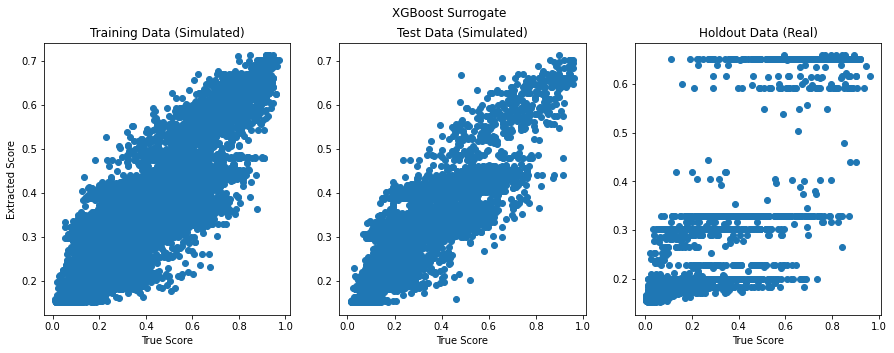

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(model_endpoint(random_train[features]), extracted_model_xgb.predict(drand_train))
axs[0].set_title("Training Data (Simulated)")
axs[0].set_ylabel('Extracted Score')
axs[0].set_xlabel('True Score')

axs[1].scatter(model_endpoint(random_test[features]), extracted_model_xgb.predict(drand_test))
axs[1].set_title("Test Data (Simulated)")
axs[1].set_xlabel('True Score')


axs[2].scatter(model_endpoint(test[features]), extracted_model_xgb.predict(dtest))
axs[2].set_title("Holdout Data (Real)")
axs[2].set_xlabel('True Score')

_ = fig.suptitle("XGBoost Surrogate")
fig.savefig('Data/Data/Figures/overfit_XGB_extraction')

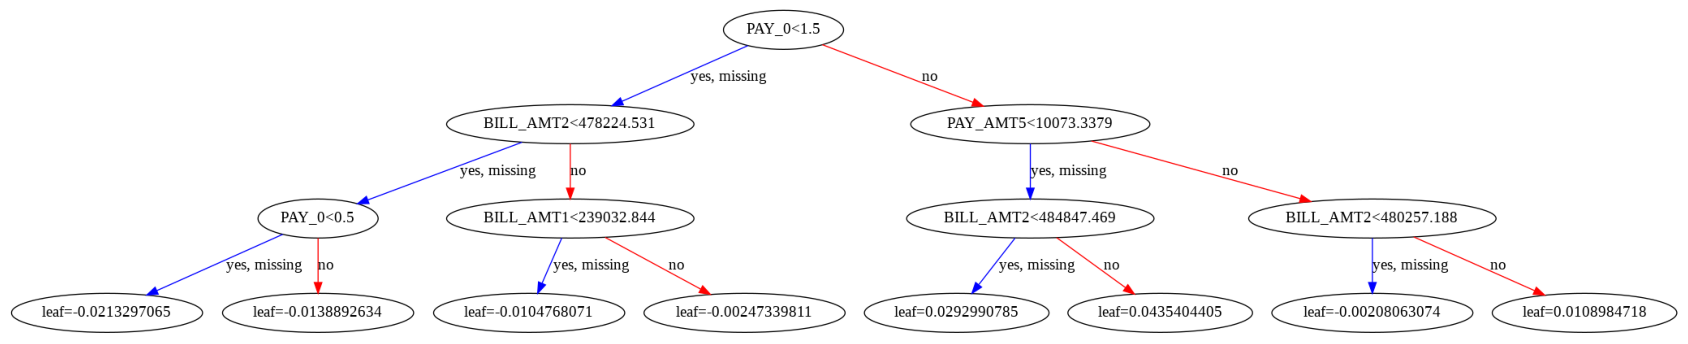

In [ ]:
# Plot the first tree
fig, ax = plt.subplots(figsize=(30,30))
xgb.plot_tree(extracted_model_xgb, num_trees=0, ax=ax)

In [ ]:


rf_surrogate_model_params = {'n_estimators': 10,
                             'max_depth': 5,
                             'random_state': SEED}
extracted_model_rf = RandomForestRegressor(**rf_surrogate_model_params).fit(random_train[features], 
                                                                      model_endpoint(random_train[features]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [ ]:
r2_train = r2_score(y_true=model_endpoint(random_train[features]), 
                     y_pred=extracted_model_rf.predict(random_train[features]))
r2_test = r2_score(y_true=model_endpoint(random_test[features]), 
                     y_pred=extracted_model_rf.predict(random_test[features]))
r2_holdout = r2_score(y_true=model_endpoint(test[features]), 
                     y_pred=extracted_model_rf.predict(test[features]))

print(f'R2 on training data (simulated): {np.round(r2_train, 3)}')
print(f'R2 on test data (simulated): {np.round(r2_test, 3)}')
print(f'R2 on real data: {np.round(r2_holdout, 3)}')

print(f'real/test: {r2_holdout/r2_test} \n')


mae_test = mean_absolute_error(y_true=model_endpoint(random_test[features]), 
                              y_pred=extracted_model_rf.predict(random_test[features]))

mae_holdout = mean_absolute_error(y_true=model_endpoint(test[features]), 
                                 y_pred=extracted_model_rf.predict(test[features]))

print(f'MAE on test data (simulated): {np.round(mae_test, 5)}')
print(f'MAE on real data: {np.round(mae_holdout, 5)}')

print(f'test/real: {mae_test/mae_holdout}')

R2 on training data (simulated): 0.718
R2 on test data (simulated): 0.714
R2 on real data: 0.659
real/test: 0.9228979450375038 

MAE on test data (simulated): 0.06876
MAE on real data: 0.09894
test/real: 0.694944130708152


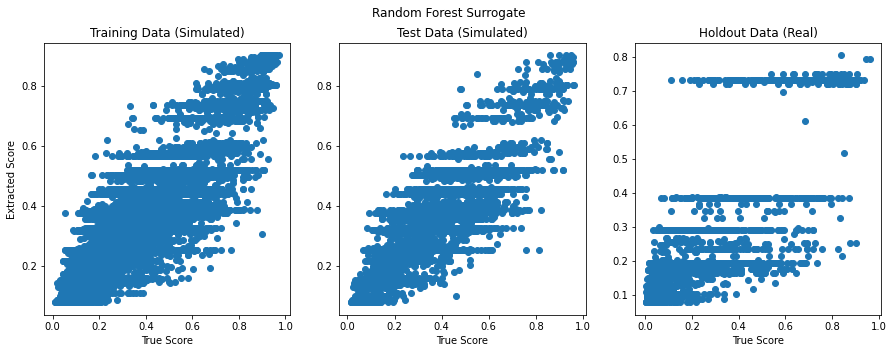

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(model_endpoint(random_train[features]), extracted_model_rf.predict(random_train[features]))
axs[0].set_title("Training Data (Simulated)")
axs[0].set_ylabel('Extracted Score')
axs[0].set_xlabel('True Score')

axs[1].scatter(model_endpoint(random_test[features]), extracted_model_rf.predict(random_test[features]))
axs[1].set_title("Test Data (Simulated)")
axs[1].set_xlabel('True Score')


axs[2].scatter(model_endpoint(test[features]), extracted_model_rf.predict(test[features]))
axs[2].set_title("Holdout Data (Real)")
axs[2].set_xlabel('True Score')

_ = fig.suptitle("Random Forest Surrogate")
fig.savefig('Data/Data/Figures/overfit_RF_extraction')

## 4. Adversarial Example Attacks

Adversarial Examples attack is an integrity attack. It compromises the correctness of
model predictions. To perform an adversarial example attack a hacker will probe
how a model responds to input data. In computer vision systems, gradient infor‐
mation is often used to fine tune images that evoke strange responses from the
model. For structured data, we can use individual conditional expectation (ICE)
or genetic algorithms to find rows of data that cause unexpected model predic‐
tions.

For this exercise, we’ll take advantage of the fact that we’ve already extracted a deci‐
sion tree representation of our model,

In [ ]:
# Let's target the leaf in our DT surrogate that follows a favorable decision path

random_frame['prediction'] = model_endpoint(random_frame[features])

# Pick an observation that receieved a high score
random_obs = random_frame.loc[(random_frame['prediction'] < 0.3) & (random_frame['prediction'] > 0.2)].iloc[0]
random_obs

LIMIT_BAL     1.147198e+06
PAY_0         6.000000e+00
PAY_2         2.000000e+00
PAY_3         8.000000e+00
PAY_4         4.000000e+00
PAY_5         6.000000e+00
PAY_6         1.000000e+00
BILL_AMT1     4.634452e+05
BILL_AMT2     1.420634e+05
BILL_AMT3     5.395007e+05
BILL_AMT4     4.862355e+05
BILL_AMT5     3.676834e+05
BILL_AMT6     8.278216e+05
PAY_AMT1      3.925474e+05
PAY_AMT2      1.340791e+05
PAY_AMT3      2.130838e+04
PAY_AMT4      7.114574e+05
PAY_AMT5      1.134584e+05
PAY_AMT6      3.428318e+05
prediction    2.556394e-01
Name: 15, dtype: float64

In [ ]:
adversarial_1 = random_obs.copy()
adversarial_1['PAY_0'] = 1.0

adversarial_2 = adversarial_1.copy()
adversarial_2['PAY_2'] = 0.0

adversarial_3 = adversarial_2.copy()
adversarial_3['PAY_0'] = 0.0

adversaries = pd.DataFrame({'original': random_obs, 
                            'example_1': adversarial_1,
                            'example_2': adversarial_2,
                            'example_3': adversarial_3}).transpose()

adversarial_example_predictions = model_endpoint(adversaries[features])

print(f"Old prediction: {adversarial_example_predictions[0][0]:.3f}")
print(f"Example 1 prediction: {adversarial_example_predictions[1][0]:.3f}")
print(f"Example 2 prediction: {adversarial_example_predictions[2][0]:.3f}")
print(f"Example 3 prediction: {adversarial_example_predictions[3][0]:.3f}")

Old prediction: 0.256
Example 1 prediction: 0.177
Example 2 prediction: 0.100
Example 3 prediction: 0.057


In [ ]:
original_quantile = len(train.loc[model_endpoint(train[features]) < adversarial_example_predictions[0]]) / len(train)
new_quantile = len(train.loc[model_endpoint(train[features]) < adversarial_example_predictions[3]]) / len(train)

print(f"Original score percentile: {100*original_quantile:.1f}%")
print(f"New score percentile: {100*new_quantile:.1f}%")

Original score percentile: 72.7%
New score percentile: 20.8%


In [ ]:
# We could do a similar exercise using the superior XGB extracted model

trees = extracted_model_xgb.trees_to_dataframe()
trees.head(30)

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,PAY_0,2.0000,0-1,0-2,0-1,282.312042,35849.0,NaN
1,0,1,0-1,BILL_AMT2,478224.5310,0-3,0-4,0-3,50.173447,10556.0,NaN
2,0,2,0-2,PAY_AMT5,10073.3379,0-5,0-6,0-5,155.244659,25293.0,NaN
3,0,3,0-3,PAY_0,1.0000,0-7,0-8,0-7,6.844757,6350.0,NaN
4,0,4,0-4,BILL_AMT1,239032.8440,0-9,0-10,0-9,6.116165,4206.0,NaN
5,0,5,0-5,BILL_AMT2,484847.4690,0-11,0-12,0-11,7.451599,1501.0,NaN
6,0,6,0-6,BILL_AMT2,480257.1880,0-13,0-14,0-13,99.216141,23792.0,NaN
7,0,7,0-7,Leaf,NaN,NaN,NaN,NaN,-0.021330,4655.0,NaN
8,0,8,0-8,Leaf,NaN,NaN,NaN,NaN,-0.013889,1695.0,NaN
9,0,9,0-9,Leaf,NaN,NaN,NaN,NaN,-0.010477,1465.0,NaN


## 5. Membership Inference Attack
Membership Inference is a confidentiality attack that seeks to compromise
model training data. It’s a complex attack that requires two models. The first is a
surrogate model similar to those that would be trained in a model extraction
attack. The second stage model is then trained to decide whether a row of data is
in the training data of the surrogate model or not. When that second-stage model
is applied to a row of data, it can decide whether that row was in the training data
of the surrogate model or not, and can often extrapolate to decide whether that
row was also in the original model training data,

In [ ]:
"""
Perform a membership inference attack.
"""

attack_negative = make_random_frame(schema_dict, 10000).append(random_valid).append(random_test)
attack_positive = random_train.copy()
attack_negative['in_train'] = 0
attack_positive['in_train'] = 1

attack_data = attack_positive.append(attack_negative).sample(frac=1).reset_index(drop=True)

In [ ]:
dattack_data = xgb.DMatrix(attack_data[features])

attack_data['prediction'] = extracted_model_xgb.predict(dattack_data, 
                                                        iteration_range=(0, extracted_model_xgb.best_iteration))
# attack_data['prediction'] = model_endpoint(attack_data)

attack_data.head(10)

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,in_train,prediction
0,7.741047e+05,1,5,7,2,-1,5,3.825222e+05,1.563087e+05,1.698492e+06,...,4.009869e+04,3.380200e+05,160212.295208,5.790698e+05,9.099407e+05,6.435144e+04,1.684413e+05,1.007401e+06,0,0.252688
1,2.234142e+06,8,4,8,4,4,8,1.498241e+06,9.559213e+05,4.171585e+05,...,1.665080e+06,6.251150e+05,232702.803640,4.185008e+04,7.131705e+04,4.267531e+04,9.061409e+05,1.447189e+05,1,0.416882
2,2.006741e+06,-1,7,1,4,3,6,5.845521e+05,3.004381e+05,4.200194e+05,...,5.340501e+05,6.566528e+05,235431.541749,4.542292e+05,1.118720e+06,1.272561e+06,6.594855e+05,7.671139e+03,1,0.198146
3,8.833743e+05,0,9,0,9,2,1,1.642220e+06,6.823426e+04,4.265532e+05,...,9.852541e+05,2.787417e+05,52053.276167,2.892251e+05,7.672275e+03,1.168657e+06,3.086262e+05,1.151426e+06,0,0.188579
4,3.006770e+05,8,4,5,8,4,8,2.740161e+05,6.655793e+05,2.855127e+06,...,9.189012e+05,1.323845e+06,203532.946947,3.906839e+05,8.007463e+04,6.085573e+04,1.281409e+06,2.796911e+05,0,0.390118
5,7.531177e+05,1,1,9,6,4,0,2.048199e+05,9.622369e+05,9.800998e+04,...,2.822446e+05,2.715271e+06,2115.071309,2.117457e+05,2.716670e+05,5.330283e+05,1.383445e+05,4.702704e+05,0,0.299548
6,8.915291e+05,7,1,9,0,7,9,1.976234e+05,5.512582e+05,1.808534e+05,...,7.058063e+04,5.673100e+05,73715.242385,5.174077e+05,3.049073e+05,1.800723e+04,2.198568e+05,6.954688e+04,1,0.413418
7,2.278108e+06,0,7,9,5,4,2,1.387995e+05,1.421507e+05,4.145218e+05,...,1.344881e+05,1.372469e+05,233502.240153,2.366588e+04,1.399352e+05,3.637175e+05,2.510796e+05,9.289959e+05,1,0.187473
8,5.501660e+04,6,3,1,4,0,5,1.431472e+05,1.450363e+06,3.430612e+05,...,1.243924e+06,3.564089e+04,270614.839950,1.126180e+05,2.604212e+05,2.720713e+05,1.838363e+05,1.381723e+05,1,0.390118
9,1.094201e+05,7,7,-1,7,5,9,6.080474e+05,2.506749e+04,1.340049e+06,...,5.119465e+04,1.104901e+05,65493.982508,1.021165e+06,4.205204e+05,4.524876e+03,1.285967e+05,2.014761e+05,0,0.333632


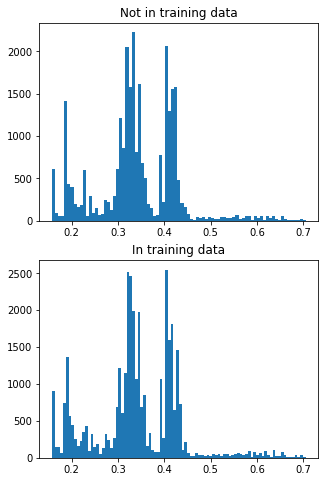

In [ ]:
# Look at the distribution of extracted model predictions for the training versus new data points.

fig, axs = plt.subplots(2, 1, figsize=(5, 8))
axs[0].hist(attack_data.loc[attack_data['in_train'] == 0]['prediction'], bins='auto')
axs[0].set_title('Not in training data')

axs[1].hist(attack_data.loc[attack_data['in_train'] == 1]['prediction'], bins='auto')
_ = axs[1].set_title('In training data')


In [ ]:
# Train an XGBoost attack model.

attack_features = features + ['prediction']
attack_target = 'in_train'

attack_train = attack_data.head(int(len(attack_data)*0.8))
attack_valid = attack_data.tail(int(len(attack_data)*0.2))

dattack_train = xgb.DMatrix(attack_train[attack_features],
                            label = attack_train[attack_target])
dattack_valid = xgb.DMatrix(attack_valid[attack_features],
                            label = attack_valid[attack_target])

base_score = attack_train[attack_target].mean()

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.05,
    'max_depth': 3,
    'base_score': base_score,
    'seed': SEED
}

# Train using early stopping on the validation dataset.
watchlist = [(dattack_train, 'train'), (dattack_valid, 'eval')]

attack_model = xgb.train(params,         
                         dattack_train,                   
                         num_boost_round=500,                     
                         evals=watchlist,
                         early_stopping_rounds=10,
                         verbose_eval=True)

[0]	train-auc:0.51691	eval-auc:0.50838
[1]	train-auc:0.52290	eval-auc:0.50948
[2]	train-auc:0.52365	eval-auc:0.50832
[3]	train-auc:0.52552	eval-auc:0.51072
[4]	train-auc:0.52800	eval-auc:0.51187
[5]	train-auc:0.52917	eval-auc:0.51146
[6]	train-auc:0.52931	eval-auc:0.51367
[7]	train-auc:0.53131	eval-auc:0.51456
[8]	train-auc:0.53473	eval-auc:0.51576
[9]	train-auc:0.53510	eval-auc:0.51569
[10]	train-auc:0.53518	eval-auc:0.51554
[11]	train-auc:0.53663	eval-auc:0.51657
[12]	train-auc:0.53665	eval-auc:0.51554
[13]	train-auc:0.53712	eval-auc:0.51598
[14]	train-auc:0.53713	eval-auc:0.51629
[15]	train-auc:0.53823	eval-auc:0.51766
[16]	train-auc:0.54005	eval-auc:0.51953
[17]	train-auc:0.54044	eval-auc:0.51901
[18]	train-auc:0.54081	eval-auc:0.51913
[19]	train-auc:0.54135	eval-auc:0.51861
[20]	train-auc:0.54185	eval-auc:0.51855
[21]	train-auc:0.54308	eval-auc:0.51790
[22]	train-auc:0.54477	eval-auc:0.51800
[23]	train-auc:0.54563	eval-auc:0.51790
[24]	train-auc:0.54579	eval-auc:0.51765
[25]	train

In [ ]:
train['in_train'] = 1
test['in_train'] = 0

attack_test = train.head(len(test)).append(test).reset_index(drop=True)
attack_test['prediction'] = model_endpoint(attack_test[features])

dattack_test = xgb.DMatrix(attack_test[attack_features],
                           label = attack_test[attack_target])

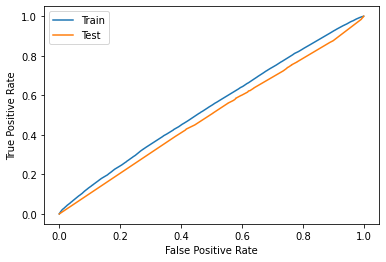

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_curve, RocCurveDisplay

fpr, tpr, _ = roc_curve(attack_train['in_train'], 
                        attack_model.predict(dattack_train, iteration_range=(0, attack_model.best_iteration)))

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
ax = roc_display.ax_

fpr, tpr, _ = roc_curve(attack_test['in_train'], 
                        attack_model.predict(dattack_test, iteration_range=(0, attack_model.best_iteration)))

ax.plot(fpr, tpr)
ax.legend(['Train', 'Test'])

### Attempting attack on the regularized and constrained model

In [ ]:
# We'll suppose access to a model prediction API endpoint that we can query without restriction

def model_endpoint(observations: pd.DataFrame):
    pred_frame = h2o.H2OFrame(observations)
    prediction = xgb_best.predict(pred_frame)['p1'].as_data_frame().values
    return prediction


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score

surrogate_model_params = {'max_depth': 4,
                         'random_state': SEED}
extracted_model_dt = DecisionTreeRegressor(**surrogate_model_params).fit(random_train[features], 
                                                                         model_endpoint(random_train[features]))

r2_train = r2_score(y_true=model_endpoint(random_train[features]), 
                     y_pred=extracted_model_dt.predict(random_train[features]))
r2_test = r2_score(y_true=model_endpoint(random_test[features]), 
                     y_pred=extracted_model_dt.predict(random_test[features]))
r2_holdout = r2_score(y_true=model_endpoint(test[features]), 
                     y_pred=extracted_model_dt.predict(test[features]))

print(f'R2 on training data (simulated): {np.round(r2_train, 3)}')
print(f'R2 on test data (simulated): {np.round(r2_test, 3)}')
print(f'R2 on real data: {np.round(r2_holdout, 3)}')

print(f'real/test: {r2_holdout/r2_test}')

R2 on training data (simulated): 0.931
R2 on test data (simulated): 0.93
R2 on real data: 0.889
real/test: 0.9567194863720975


In [ ]:
mae_test = mean_absolute_error(y_true=model_endpoint(random_test[features]), 
                              y_pred=extracted_model_dt.predict(random_test[features]))

mae_holdout = mean_absolute_error(y_true=model_endpoint(test[features]), 
                                 y_pred=extracted_model_dt.predict(test[features]))

print(f'MAE on test data (simulated): {np.round(mae_test, 5)}')
print(f'MAE on real data: {np.round(mae_holdout, 5)}')

print(f'test/real: {mae_test/mae_holdout}')

MAE on test data (simulated): 0.03876
MAE on real data: 0.04513
test/real: 0.8589336991318512


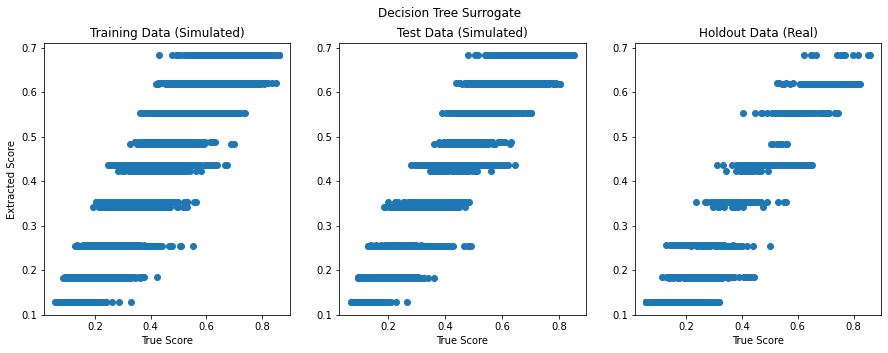

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(model_endpoint(random_train[features]), extracted_model_dt.predict(random_train[features]))
axs[0].set_title("Training Data (Simulated)")
axs[0].set_ylabel('Extracted Score')
axs[0].set_xlabel('True Score')

axs[1].scatter(model_endpoint(random_test[features]), extracted_model_dt.predict(random_test[features]))
axs[1].set_title("Test Data (Simulated)")
axs[1].set_xlabel('True Score')


axs[2].scatter(model_endpoint(test[features]), extracted_model_dt.predict(test[features]))
axs[2].set_title("Holdout Data (Real)")
axs[2].set_xlabel('True Score')

_ = fig.suptitle("Decision Tree Surrogate")
fig.savefig('Data/Data/Figures/constrained_DT_extraction')

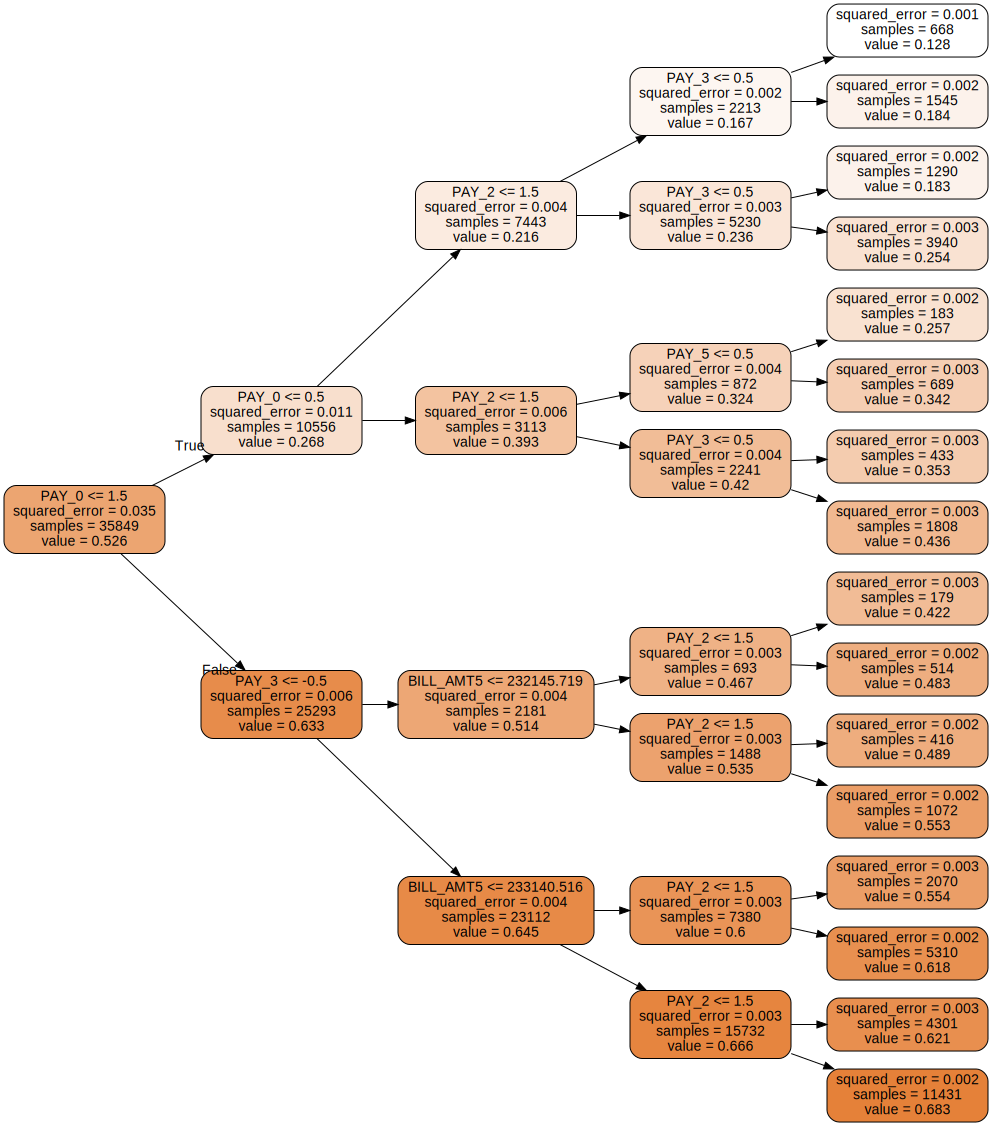

In [ ]:
import graphviz

dot_data = tree.export_graphviz(extracted_model_dt, 
                                max_depth=5,
                                rounded=True,
                                out_file=None, 
                                feature_names=features,  
                                filled=True,
                                rotate=True)

graph = graphviz.Source(dot_data, format="svg") 
graph

In [ ]:
drand_train = xgb.DMatrix(random_train[features], 
                          label=model_endpoint(random_train[features]))

drand_valid = xgb.DMatrix(random_valid[features], 
                          label=model_endpoint(random_valid[features]))

drand_test = xgb.DMatrix(random_test[features], 
                          label=model_endpoint(random_test[features]))

base_score = model_endpoint(random_train[features]).mean()

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'reg_lambda': 0.25,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'base_score': base_score,
    'seed': SEED
}

# Train using early stopping on the validation dataset.
watchlist = [(drand_train, 'train'), (drand_valid, 'eval')]

extracted_model_xgb = xgb.train(params,         
                                drand_train,                   
                                num_boost_round=20,                     
                                evals=watchlist,
                                early_stopping_rounds=5,
                                verbose_eval=False)
print(f"Done. Final number of trees: {extracted_model_xgb.best_ntree_limit}")

Done. Final number of trees: 20


In [ ]:
dtest = xgb.DMatrix(test[features], 
                    label=test[target])

r2_train = r2_score(y_true=model_endpoint(random_train[features]), 
                     y_pred=extracted_model_xgb.predict(drand_train))
r2_test = r2_score(y_true=model_endpoint(random_test[features]), 
                     y_pred=extracted_model_xgb.predict(drand_test))
r2_holdout = r2_score(y_true=model_endpoint(test[features]), 
                     y_pred=extracted_model_xgb.predict(dtest))

print(f'R2 on training data (simulated): {np.round(r2_train, 3)}')
print(f'R2 on test data (simulated): {np.round(r2_test, 3)}')
print(f'R2 on real data: {np.round(r2_holdout, 3)}')

print(f'real/test: {r2_holdout/r2_test}')

R2 on training data (simulated): 0.904
R2 on test data (simulated): 0.904
R2 on real data: 0.821
real/test: 0.9089574299960501


In [ ]:
mae_test = mean_absolute_error(y_true=model_endpoint(random_test[features]), 
                              y_pred=extracted_model_xgb.predict(drand_test))

mae_holdout = mean_absolute_error(y_true=model_endpoint(test[features]), 
                                 y_pred=extracted_model_xgb.predict(dtest))

print(f'MAE on test data (simulated): {np.round(mae_test, 5)}')
print(f'MAE on real data: {np.round(mae_holdout, 5)}')

print(f'test/real: {mae_test/mae_holdout}')

MAE on test data (simulated): 0.04786
MAE on real data: 0.06737
test/real: 0.7103587146839606


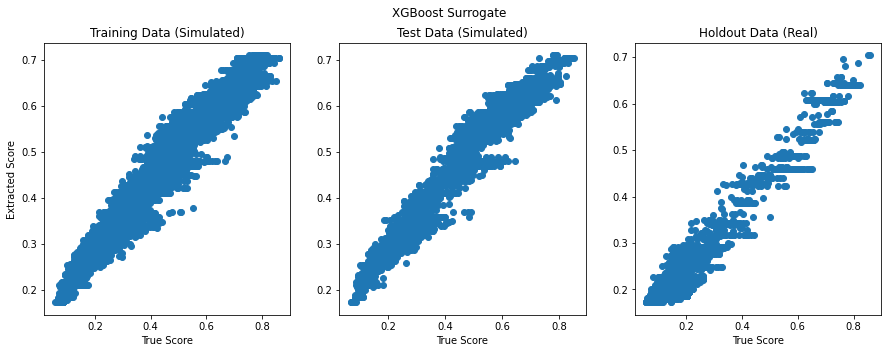

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(model_endpoint(random_train[features]), extracted_model_xgb.predict(drand_train))
axs[0].set_title("Training Data (Simulated)")
axs[0].set_ylabel('Extracted Score')
axs[0].set_xlabel('True Score')

axs[1].scatter(model_endpoint(random_test[features]), extracted_model_xgb.predict(drand_test))
axs[1].set_title("Test Data (Simulated)")
axs[1].set_xlabel('True Score')


axs[2].scatter(model_endpoint(test[features]), extracted_model_xgb.predict(dtest))
axs[2].set_title("Holdout Data (Real)")
axs[2].set_xlabel('True Score')

_ = fig.suptitle("XGBoost Surrogate")
fig.savefig('Data/Data/Figures/constrained_XGB_extraction')

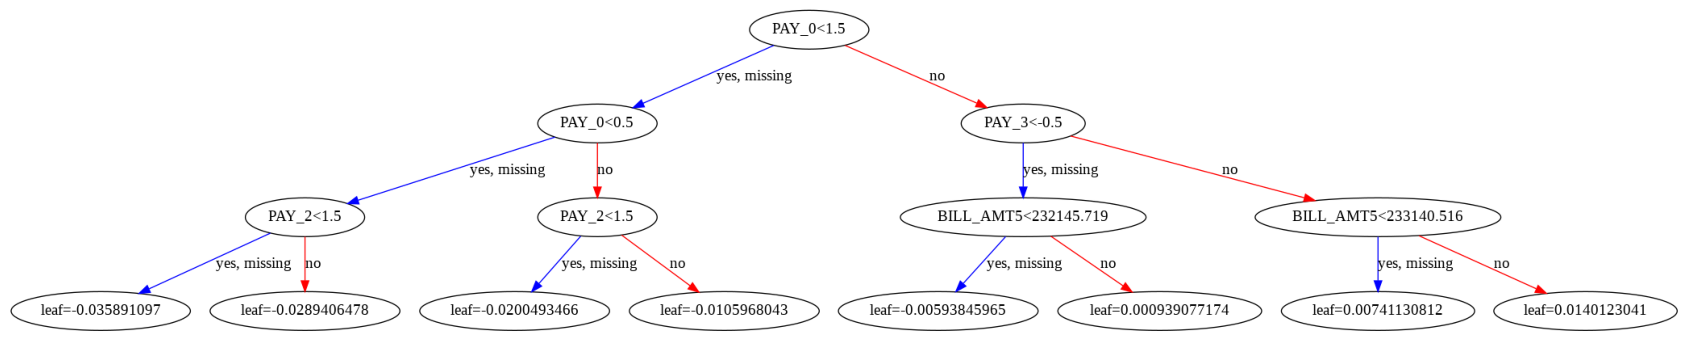

In [ ]:
# Plot the first tree
fig, ax = plt.subplots(figsize=(30,30))
xgb.plot_tree(extracted_model_xgb, num_trees=0, ax=ax)

In [ ]:


rf_surrogate_model_params = {'n_estimators': 10,
                             'max_depth': 5,
                             'random_state': SEED}
extracted_model_rf = RandomForestRegressor(**rf_surrogate_model_params).fit(random_train[features], 
                                                                      model_endpoint(random_train[features]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [ ]:
r2_train = r2_score(y_true=model_endpoint(random_train[features]), 
                     y_pred=extracted_model_rf.predict(random_train[features]))
r2_test = r2_score(y_true=model_endpoint(random_test[features]), 
                     y_pred=extracted_model_rf.predict(random_test[features]))
r2_holdout = r2_score(y_true=model_endpoint(test[features]), 
                     y_pred=extracted_model_rf.predict(test[features]))

print(f'R2 on training data (simulated): {np.round(r2_train, 3)}')
print(f'R2 on test data (simulated): {np.round(r2_test, 3)}')
print(f'R2 on real data: {np.round(r2_holdout, 3)}')

print(f'real/test: {r2_holdout/r2_test} \n')


mae_test = mean_absolute_error(y_true=model_endpoint(random_test[features]), 
                              y_pred=extracted_model_rf.predict(random_test[features]))

mae_holdout = mean_absolute_error(y_true=model_endpoint(test[features]), 
                                 y_pred=extracted_model_rf.predict(test[features]))

print(f'MAE on test data (simulated): {np.round(mae_test, 5)}')
print(f'MAE on real data: {np.round(mae_holdout, 5)}')

print(f'test/real: {mae_test/mae_holdout}')

R2 on training data (simulated): 0.952
R2 on test data (simulated): 0.951
R2 on real data: 0.85
real/test: 0.8941296356755304 

MAE on test data (simulated): 0.03109
MAE on real data: 0.05323
test/real: 0.5839538262812246


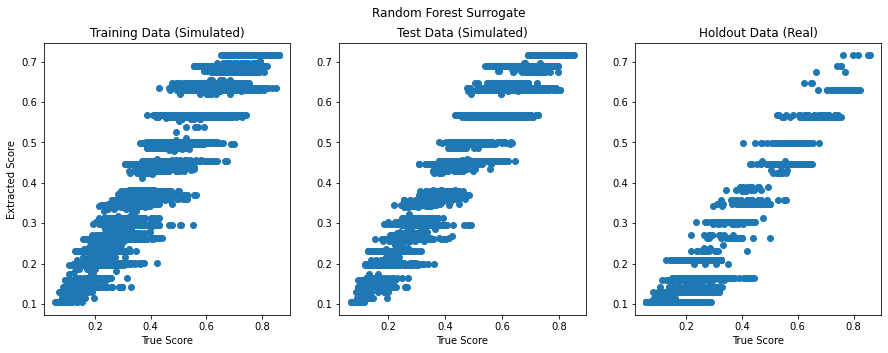

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(model_endpoint(random_train[features]), extracted_model_rf.predict(random_train[features]))
axs[0].set_title("Training Data (Simulated)")
axs[0].set_ylabel('Extracted Score')
axs[0].set_xlabel('True Score')

axs[1].scatter(model_endpoint(random_test[features]), extracted_model_rf.predict(random_test[features]))
axs[1].set_title("Test Data (Simulated)")
axs[1].set_xlabel('True Score')


axs[2].scatter(model_endpoint(test[features]), extracted_model_rf.predict(test[features]))
axs[2].set_title("Holdout Data (Real)")
axs[2].set_xlabel('True Score')

_ = fig.suptitle("Random Forest Surrogate")
fig.savefig('Data/Data/Figures/constrained_RF_extraction')

In [ ]:
# Let's target the leaf in our DT surrogate that follows a favorable decision path

random_frame['prediction'] = model_endpoint(random_frame[features])

# Pick an observation that receieved a high score
random_obs = random_frame.loc[(random_frame['prediction'] < 0.3) & (random_frame['prediction'] > 0.2)].iloc[0]
random_obs

LIMIT_BAL      21145.169332
PAY_0             -1.000000
PAY_2              2.000000
PAY_3              2.000000
PAY_4              2.000000
PAY_5              0.000000
PAY_6              3.000000
BILL_AMT1     120225.625125
BILL_AMT2     500166.376921
BILL_AMT3     370327.745557
BILL_AMT4     193902.848808
BILL_AMT5      83311.078603
BILL_AMT6     404177.908303
PAY_AMT1      374034.582976
PAY_AMT2      385292.007380
PAY_AMT3      197194.782547
PAY_AMT4      314890.653648
PAY_AMT5      919219.154693
PAY_AMT6      538047.554352
prediction         0.285915
Name: 6, dtype: float64

In [ ]:
adversarial_1 = random_obs.copy()
adversarial_1['PAY_2'] = 0

adversarial_2 = adversarial_1.copy()
adversarial_2['PAY_3'] = 0

adversarial_3 = adversarial_2.copy()
adversarial_3['PAY_0'] = 0.0

adversaries = pd.DataFrame({'original': random_obs, 
                            'example_1': adversarial_1,
                            'example_2': adversarial_2,
                            'example_3': adversarial_3}).transpose()

adversarial_example_predictions = model_endpoint(adversaries[features])

print(f"Old prediction: {adversarial_example_predictions[0][0]:.3f}")
print(f"Example 1 prediction: {adversarial_example_predictions[1][0]:.3f}")
print(f"Example 2 prediction: {adversarial_example_predictions[2][0]:.3f}")
print(f"Example 3 prediction: {adversarial_example_predictions[3][0]:.3f}")

Old prediction: 0.286
Example 1 prediction: 0.192
Example 2 prediction: 0.151
Example 3 prediction: 0.151


In [ ]:
original_quantile = len(train.loc[model_endpoint(train[features]) < adversarial_example_predictions[0]]) / len(train)
new_quantile = len(train.loc[model_endpoint(train[features]) < adversarial_example_predictions[3]]) / len(train)

print(f"Original score percentile: {100*original_quantile:.1f}%")
print(f"New score percentile: {100*new_quantile:.1f}%")

Original score percentile: 79.6%
New score percentile: 48.9%


In [ ]:
# Let's target the leaf in our DT surrogate that follows a favorable decision path

random_frame['prediction'] = model_endpoint(random_frame[features])

# Pick an observation that receieved a high score
random_obs = random_frame.loc[(random_frame['prediction'] < 0.6) & (random_frame['prediction'] > 0.5)].iloc[0]

In [ ]:
adversarial_1 = random_obs.copy()
adversarial_1['PAY_0'] = -1

adversarial_2 = adversarial_1.copy()
adversarial_2['PAY_2'] = 0

adversarial_3 = adversarial_2.copy()
adversarial_3['PAY_3'] = 0

adversaries = pd.DataFrame({'original': random_obs, 
                            'example_1': adversarial_1,
                            'example_2': adversarial_2,
                            'example_3': adversarial_3}).transpose()

adversarial_example_predictions = model_endpoint(adversaries[features])

print(f"Old prediction: {adversarial_example_predictions[0][0]:.3f}")
print(f"Example 1 prediction: {adversarial_example_predictions[1][0]:.3f}")
print(f"Example 2 prediction: {adversarial_example_predictions[2][0]:.3f}")
print(f"Example 3 prediction: {adversarial_example_predictions[3][0]:.3f}")

Old prediction: 0.545
Example 1 prediction: 0.412
Example 2 prediction: 0.314
Example 3 prediction: 0.242


In [ ]:
original_quantile = len(train.loc[model_endpoint(train[features]) < adversarial_example_predictions[0]]) / len(train)
new_quantile = len(train.loc[model_endpoint(train[features]) < adversarial_example_predictions[3]]) / len(train)

print(f"Original score percentile: {100*original_quantile:.1f}%")
print(f"New score percentile: {100*new_quantile:.1f}%")

Original score percentile: 89.7%
New score percentile: 75.9%


In [ ]:
"""
Perform a membership inference attack.
"""

attack_negative = make_random_frame(schema_dict, 10000).append(random_valid).append(random_test)
attack_positive = random_train.copy()
attack_negative['in_train'] = 0
attack_positive['in_train'] = 1

attack_data = attack_positive.append(attack_negative).sample(frac=1).reset_index(drop=True)

In [ ]:
dattack_data = xgb.DMatrix(attack_data[features])

attack_data['prediction'] = extracted_model_xgb.predict(dattack_data, 
                                                        iteration_range=(0, extracted_model_xgb.best_iteration))
# attack_data['prediction'] = model_endpoint(attack_data)

attack_data.head(10)

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,in_train,prediction
0,3.532671e+05,3,6,3,9,0,7,4.249143e+05,6.427655e+04,1.427683e+05,...,3.658471e+06,4.828197e+05,1.983541e+05,7.075546e+05,282101.624594,237985.458388,164357.538228,606510.760601,0,0.620942
1,3.499011e+05,5,9,-1,5,1,6,4.861733e+05,1.223341e+05,2.814394e+05,...,7.448494e+05,3.675559e+05,1.523356e+04,1.000044e+05,721726.742190,595030.683807,65715.650271,82806.726411,1,0.560192
2,2.510857e+06,4,8,7,3,1,-1,1.761015e+06,4.477663e+05,1.741556e+05,...,1.831996e+06,1.500997e+06,1.308210e+05,1.339618e+05,142474.230881,567713.496342,98717.149281,578674.665667,0,0.615547
3,5.108782e+04,2,8,9,1,8,8,2.919804e+06,1.159670e+05,3.084323e+05,...,3.502891e+05,4.302844e+05,1.551763e+05,1.303735e+06,321835.299522,67884.969529,44047.312996,89473.132158,0,0.641994
4,1.883075e+05,0,4,3,5,7,8,3.284158e+05,2.480358e+05,1.903364e+05,...,1.260028e+06,5.174183e+05,7.112088e+05,3.031434e+05,35110.385488,243725.233566,92395.790721,31210.485043,0,0.338033
5,1.582516e+05,2,7,7,-1,1,9,1.446374e+06,1.304415e+05,8.613840e+04,...,9.158656e+05,3.998826e+05,7.705667e+04,6.081977e+05,46632.269197,392629.862319,274606.226499,45192.864493,1,0.641994
6,1.666749e+05,6,6,2,4,6,-1,2.434958e+05,4.123463e+05,3.193616e+05,...,9.242161e+05,7.249556e+05,1.034411e+06,1.271945e+05,174693.939707,139874.216723,67583.656063,26813.851045,0,0.615547
7,2.034970e+05,6,6,9,3,2,7,1.012826e+06,1.101667e+06,4.697881e+05,...,1.157165e+05,5.773211e+05,3.285587e+05,2.127042e+04,896912.148389,588521.533930,268749.781236,67686.769830,0,0.602743
8,1.193527e+06,1,8,5,8,9,6,1.301173e+06,7.893954e+05,4.239026e+06,...,1.349520e+06,7.207526e+05,9.785152e+04,4.862949e+04,614612.651630,213264.556486,359972.299057,95426.832921,0,0.471213
9,2.744731e+06,2,1,8,7,8,4,4.700999e+05,8.663200e+05,1.081203e+06,...,5.479399e+04,7.515999e+05,1.547550e+05,7.132272e+05,406604.105405,232644.673548,122115.981584,695522.903232,0,0.576626


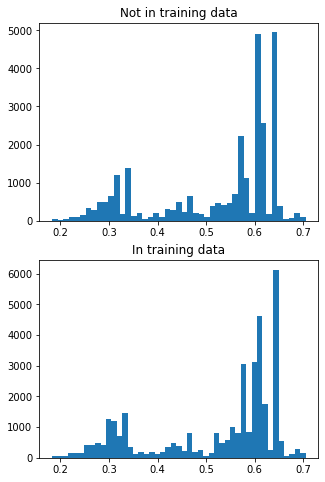

In [ ]:
# Look at the distribution of extracted model predictions for the training versus new data points. We expect
#  the training data points to be most concentrated on the extremes of [0, 1]

"""
Eh - not really. Hopefully this happens:

"If we use model-based synthesis from Section V-C, all of the raw training data for the attack model is drawn 
from the records that are classified by the target model with high confidence. This is true, however, both for 
the records used in the shadow models’ training datasets and for the test records left out of these datasets. 
Therefore, it is not the case that the attack model simply learns to recognize inputs that are classified with 
high confidence. Instead, it learns to perform a much subtler task: how to distinguish between the training 
inputs classified with high confidence and other, non-training inputs that are also classified with high 
confidence."
"""

fig, axs = plt.subplots(2, 1, figsize=(5, 8))
axs[0].hist(attack_data.loc[attack_data['in_train'] == 0]['prediction'], bins='auto')
axs[0].set_title('Not in training data')

axs[1].hist(attack_data.loc[attack_data['in_train'] == 1]['prediction'], bins='auto')
_ = axs[1].set_title('In training data')


In [ ]:
# Train an XGBoost attack model.

attack_features = features + ['prediction']
attack_target = 'in_train'

attack_train = attack_data.head(int(len(attack_data)*0.8))
attack_valid = attack_data.tail(int(len(attack_data)*0.2))

dattack_train = xgb.DMatrix(attack_train[attack_features],
                            label = attack_train[attack_target])
dattack_valid = xgb.DMatrix(attack_valid[attack_features],
                            label = attack_valid[attack_target])

base_score = attack_train[attack_target].mean()

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.05,
    'max_depth': 3,
    'base_score': base_score,
    'seed': SEED
}

# Train using early stopping on the validation dataset.
watchlist = [(dattack_train, 'train'), (dattack_valid, 'eval')]

attack_model = xgb.train(params,         
                         dattack_train,                   
                         num_boost_round=500,                     
                         evals=watchlist,
                         early_stopping_rounds=10,
                         verbose_eval=True)

[0]	train-auc:0.51129	eval-auc:0.50338
[1]	train-auc:0.51290	eval-auc:0.50159
[2]	train-auc:0.51624	eval-auc:0.50727
[3]	train-auc:0.51972	eval-auc:0.50516
[4]	train-auc:0.51943	eval-auc:0.50617
[5]	train-auc:0.51978	eval-auc:0.50577
[6]	train-auc:0.52548	eval-auc:0.51490
[7]	train-auc:0.52614	eval-auc:0.51470
[8]	train-auc:0.52808	eval-auc:0.51430
[9]	train-auc:0.52733	eval-auc:0.51339
[10]	train-auc:0.52994	eval-auc:0.51375
[11]	train-auc:0.53538	eval-auc:0.51308
[12]	train-auc:0.53590	eval-auc:0.51342
[13]	train-auc:0.53685	eval-auc:0.51380
[14]	train-auc:0.53783	eval-auc:0.51387
[15]	train-auc:0.53766	eval-auc:0.51394


In [ ]:
train['in_train'] = 1
test['in_train'] = 0

attack_test = train.head(len(test)).append(test).reset_index(drop=True)
attack_test['prediction'] = model_endpoint(attack_test[features])

dattack_test = xgb.DMatrix(attack_test[attack_features],
                           label = attack_test[attack_target])

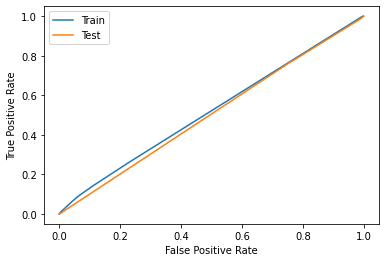

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_curve, RocCurveDisplay

fpr, tpr, _ = roc_curve(attack_train['in_train'], 
                        attack_model.predict(dattack_train, iteration_range=(0, attack_model.best_iteration)))

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
ax = roc_display.ax_

fpr, tpr, _ = roc_curve(attack_test['in_train'], 
                        attack_model.predict(dattack_test, iteration_range=(0, attack_model.best_iteration)))

ax.plot(fpr, tpr)
ax.legend(['Train', 'Test'])

In [ ]:
# Let's try and improve the random data to get more realisic points. We'll implement Algorithm 1 from Shokri et al.

def model_endpoint_data_synthesis(schema, features, predict_class,
                                  iter_max=100, k_min=2, max_rejects=5, 
                                  confidence_bound=0.3):
    
    # Initialize a random record from the schema dict
    random_obs = make_random_frame(schema, 1)
    last_accepted = random_obs
    # The objective is simply the class probability
    objective = 0
    num_failed_iterations = 0
    k = len(features)
    j = 0
    
    for i in range(iter_max):
        obj_i = predict_class(random_obs[features])
        if obj_i > objective:
            if obj_i > confidence_bound:
                if np.random.rand() < obj_i:
                    return random_obs
            num_failed_iterations = 0
            objective = obj_i
            last_accepted = random_obs.copy()
        else:
            j += 1
            if j > max_rejects:
                k = np.max([k_min, int(np.ceil(k/2))])
                j = 0
        
        # Randomize k features in x
        random_obs = randomize_features(last_accepted, schema, k)
        
    return

def randomize_features(obs, schema, k):
    features_to_modify = np.random.choice(list(schema.keys()), k, replace=False)
    
    for feature in features_to_modify:
        if schema[feature]['dist'] == 'uniform':
            obs[feature] = np.random.choice(schema[feature]['values'],
                                            size=1)[0]

        # simulate LIMIT_BAL, BILL_AMT*, PAY_AMT* features
        if schema[feature]['dist'] == 'exponential':
            obs[feature] = schema[feature]['min'] + np.random.exponential(scale=schema[feature]['scale'], 
                                                                          size=1)
    return obs


def randomize_features_vectorized(obs, schema):
    features_to_modify = [np.random.choice(list(schema.keys()), k, replace=False) for k in obs['num_to_shuffle']]
    
    for i, features in enumerate(features_to_modify):
        for feature in features: 
            if schema[feature]['dist'] == 'uniform':
                obs.iloc[i][feature] = np.random.choice(schema[feature]['values'],
                                                size=1)[0]

            if schema[feature]['dist'] == 'exponential':
                obs.iloc[i][feature] = schema[feature]['min'] + np.random.exponential(scale=schema[feature]['scale'], 
                                                                              size=1)
    
    return obs

def make_random_frame(schema, N):
    random_frame = pd.DataFrame(columns=list(schema.keys())) # init empty frame


    for j in list(schema.keys()): # loop through features

        # simulate PAY_* features
        if schema[j]['dist'] == 'uniform':
            random_frame[j] = np.random.choice(schema[j]['values'],
                                               size=N)

        # simulate LIMIT_BAL, BILL_AMT*, PAY_AMT* features
        if schema[j]['dist'] == 'exponential':
            random_frame[j] = schema[j]['min'] + np.random.exponential(scale=schema[j]['scale'], 
                                                                       size=N)
            
    return random_frame


## 6. Synthetic Data Generation

We use the below code to generate new synthetic data points (eventually Data/synthetic_data.csv)

In [ ]:
# new_random_frame = pd.DataFrame(columns=list(schema_dict.keys()))

# schema_dict = {'PAY_0': {'values': np.arange(-1, 10), 'dist': 'uniform'},
#                'PAY_2': {'values': np.arange(-1, 10), 'dist': 'uniform'},
#                'PAY_3': {'values': np.arange(-1, 10), 'dist': 'uniform'},
#                'PAY_4': {'values': np.arange(-1, 10), 'dist': 'uniform'},
#                'PAY_5': {'values': np.arange(-1, 10), 'dist': 'uniform'},
#                'PAY_6': {'values': np.arange(-1, 10), 'dist': 'uniform'},
#                'LIMIT_BAL': {'min': 500, 'scale': 1000000, 'dist': 'exponential'},
#                'BILL_AMT1': {'min': 0, 'scale': 600000, 'dist': 'exponential'},
#                'BILL_AMT2': {'min': 0, 'scale': 600000, 'dist': 'exponential'},
#                'BILL_AMT3': {'min': 0, 'scale': 600000, 'dist': 'exponential'},
#                'BILL_AMT4': {'min': 0, 'scale': 600000, 'dist': 'exponential'},
#                'BILL_AMT5': {'min': 0, 'scale': 600000, 'dist': 'exponential'},
#                'BILL_AMT6': {'min': 0, 'scale': 600000, 'dist': 'exponential'},
#                'PAY_AMT1': {'min': 0, 'scale': 100000, 'dist': 'exponential'},
#                'PAY_AMT2': {'min': 0, 'scale': 100000, 'dist': 'exponential'},
#                'PAY_AMT3': {'min': 0, 'scale': 100000, 'dist': 'exponential'},
#                'PAY_AMT4': {'min': 0, 'scale': 100000, 'dist': 'exponential'},
#                'PAY_AMT5': {'min': 0, 'scale': 100000, 'dist': 'exponential'},
#                'PAY_AMT6': {'min': 0, 'scale': 100000, 'dist': 'exponential'}}

# while len(new_random_frame) < 500:
# # while len(new_random_frame) < 10:
#     random_obs = model_endpoint_data_synthesis(schema_dict, features, predict_class=lambda x: 1 - model_endpoint(x), 
#                                                confidence_bound=0.9, k_min=8,
#                                                iter_max=50)
#     new_random_frame = new_random_frame.append(random_obs)

    
# while len(new_random_frame) < 1500:
# # while len(new_random_frame) < 10:
#     random_obs = model_endpoint_data_synthesis(schema_dict, features, predict_class=lambda x: 1 - model_endpoint(x), 
#                                                confidence_bound=0.85, k_min=8,
#                                                iter_max=50)
#     new_random_frame = new_random_frame.append(random_obs)


# print(f"Done with stage 1.")

# while len(new_random_frame) < 1600:
# # while len(new_random_frame) < 15:
#     random_obs = model_endpoint_data_synthesis(schema_dict, features, predict_class=lambda x: 1 - model_endpoint(x), 
#                                                confidence_bound=0.94, k_min=8,
#                                                iter_max=50)
#     new_random_frame = new_random_frame.append(random_obs)

# print(f"Done with stage 2.")

# schema_dict = {'PAY_0': {'values': np.arange(-1, 10), 'dist': 'uniform'},
#                'PAY_2': {'values': np.arange(-1, 10), 'dist': 'uniform'},
#                'PAY_3': {'values': np.arange(-1, 10), 'dist': 'uniform'},
#                'PAY_4': {'values': np.arange(-1, 10), 'dist': 'uniform'},
#                'PAY_5': {'values': np.arange(-1, 10), 'dist': 'uniform'},
#                'PAY_6': {'values': np.arange(-1, 10), 'dist': 'uniform'},
#                'LIMIT_BAL': {'min': 500, 'scale': 1000000, 'dist': 'exponential'},
#                'BILL_AMT1': {'min': 0, 'scale': 1000000, 'dist': 'exponential'},
#                'BILL_AMT2': {'min': 0, 'scale': 1000000, 'dist': 'exponential'},
#                'BILL_AMT3': {'min': 0, 'scale': 1000000, 'dist': 'exponential'},
#                'BILL_AMT4': {'min': 0, 'scale': 1000000, 'dist': 'exponential'},
#                'BILL_AMT5': {'min': 0, 'scale': 1000000, 'dist': 'exponential'},
#                'BILL_AMT6': {'min': 0, 'scale': 1000000, 'dist': 'exponential'},
#                'PAY_AMT1': {'min': 0, 'scale': 80000, 'dist': 'exponential'},
#                'PAY_AMT2': {'min': 0, 'scale': 80000, 'dist': 'exponential'},
#                'PAY_AMT3': {'min': 0, 'scale': 80000, 'dist': 'exponential'},
#                'PAY_AMT4': {'min': 0, 'scale': 80000, 'dist': 'exponential'},
#                'PAY_AMT5': {'min': 0, 'scale': 80000, 'dist': 'exponential'},
#                'PAY_AMT6': {'min': 0, 'scale': 800000, 'dist': 'exponential'}}

# while len(new_random_frame) < 1800:
# # while len(new_random_frame) < 20:
#     random_obs = model_endpoint_data_synthesis(schema_dict, features, predict_class=lambda x: model_endpoint(x), 
#                                                confidence_bound=0.4, k_min=8,
#                                                iter_max=50)
#     new_random_frame = new_random_frame.append(random_obs)

# print(f"Done with stage 3.")
# new_random_frame.to_csv(f"stage_3.csv")
    
# while len(new_random_frame) < 2000:
# # while len(new_random_frame) < 25:
#     random_obs = model_endpoint_data_synthesis(schema_dict, features, predict_class=lambda x: model_endpoint(x), 
#                                                confidence_bound=0.5, k_min=8,
#                                                iter_max=50)
#     new_random_frame = new_random_frame.append(random_obs)

# print(f"Done with stage 4.")
# new_random_frame.to_csv(f"stage_4.csv")

# while len(new_random_frame) < 2200:
# # while len(new_random_frame) < 30:
#     random_obs = model_endpoint_data_synthesis(schema_dict, features, predict_class=lambda x: model_endpoint(x), 
#                                                confidence_bound=0.6, k_min=8,
#                                                iter_max=50)
#     new_random_frame = new_random_frame.append(random_obs)

# print(f"Done with stage 5.")

# while len(new_random_frame) < 2300:
# # while len(new_random_frame) < 35:
#     random_obs = model_endpoint_data_synthesis(schema_dict, features, predict_class=lambda x: model_endpoint(x), 
#                                                confidence_bound=0.7, k_min=8,
#                                                iter_max=50)
#     new_random_frame = new_random_frame.append(random_obs)
    

# while len(new_random_frame) < 2500:
# # while len(new_random_frame) < 35:
#     random_obs = model_endpoint_data_synthesis(schema_dict, features, predict_class=lambda x: model_endpoint(x), 
#                                                confidence_bound=0.65, k_min=8,
#                                                iter_max=50)
#     new_random_frame = new_random_frame.append(random_obs)
    
# for categorical_feat in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
#     new_random_frame[categorical_feat] = new_random_frame[categorical_feat].astype(int)
    
# new_random_frame.to_csv(f"new_synthetic_data.csv")


In [ ]:
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? Y
H2O session _sid_b6b9 closed.
